# 1. Medical transcription prediction:




Diagnostics prediction is a project which aims to automatically predict diagnostics needed for a patient with certain anamnesis.

The anamnesis is represented by a raw text file with doctor's notes about the patient, including his/her age, compaints described in free way, patient's history and so on. It is unstructured - different sections of oen patient anamnesis may abscent in another's.

The target labels are represented by the name of needed diagnostics procedure.

The value on the solution might be found in helping a doctor to find the optimal solution for diasnostics order. Patient can save time and money, and doctor can serve a patient more efficiently on sparing time for unnecessary diagnostics. Moreover, in difficult cases the algorithm may help a doctor to find a diagnosys faster, which in some cases may be extremely valuable, up to saving lives.

Theoretically some regularities found by the algorithm may help medical researchers to find the idea of treating some deseases, based on their unobvious interconnections with some symptoms.


# 2. Environment Preparation

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from sklearn import preprocessing
import re
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyspellchecker
from spellchecker import SpellChecker
!pip install matplotlib wordcloud
from wordcloud import WordCloud
import nltk
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import warnings
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from sklearn.linear_model import LogisticRegression
!pip install tabulate


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. Data Loading

In [2]:
url = 'https://raw.githubusercontent.com/Praajina/Oversampling-SMOTE-and-ADASYN/main/mtsamples.csv'

In [3]:
df = pd.read_csv(url)
df.head(10)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


In [4]:
df.shape

(4999, 6)

In [5]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df

pd.set_option('display.max_colwidth', 255)
df =pd.read_csv(url)
df.drop('Unnamed: 0', axis=1, inplace=True)
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"


All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped

# 4. Data review

In order to query the data, I would need to know how big the dataset is and how to arrange the null values descending.

In [6]:
word_count_df = df.groupby('medical_specialty')['transcription'].apply(lambda x: x.str.split().str.len().sum()).reset_index()
word_count_df.columns = ['Medical Specialty', 'Word Count']
word_count_df = word_count_df.sort_values(by='Word Count', ascending=False).reset_index(drop=True)
word_count_df

,Medical Specialty,Word Count
0,Surgery,526754.0
1,Consult - History and Phy.,287961.0
2,Orthopedic,198489.0
3,Cardiovascular / Pulmonary,160867.0
4,General Medicine,120978.0
5,Neurology,110677.0
6,Gastroenterology,80347.0
7,Radiology,74969.0
8,Obstetrics / Gynecology,72589.0
9,Urology,63419.0


In [7]:
total_word_count = df['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 2311419


Sample Size of Each Medical Specialty

In [8]:
vc(df, 'medical_specialty')

STATUS: Value counts of "medical_specialty"...


,count,percentage (%)
medical_specialty,,
Surgery,1103,22.064413
Consult - History and Phy.,516,10.322064
Cardiovascular / Pulmonary,372,7.441488
Orthopedic,355,7.101420
Radiology,273,5.461092
General Medicine,259,5.181036
Gastroenterology,230,4.600920
Neurology,223,4.460892
SOAP / Chart / Progress Notes,166,3.320664


In [9]:
print('The number of rows:', df.shape[0])
print('The number of columns:', df.shape[1])

The number of rows: 4999
The number of columns: 5


In [10]:
# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

keywords             1068
transcription          33
description             0
medical_specialty       0
sample_name             0
dtype: int64

We can observe that there are 33 rows containing null values in transcription. They should be removed as transcription is our only predictors in this text classification task.

In [11]:
# to remove transcription rows that is empty
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


dropping the null value in transcription there is no null values.

In [12]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard...","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal lv"
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...,"cardiovascular / pulmonary, 2-d, doppler, echocardiogram, annular, aortic root, aortic valve, atrial, atrium, calcification, cavity, ejection fraction, mitral, obliteration, outflow, regurgitation, relaxation pattern, stenosis, systolic function, tric..."


In [13]:
df.drop(['description', 'sample_name', 'keywords'], axis=1, inplace=True)
df.head()

<ipython-input-13-609614d21251>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['description', 'sample_name', 'keywords'], axis=1, inplace=True)


,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...


The'medical_specialty' attribute targets the 'target labels' topic. The value counts are visualized in a bar chart using the matplotlib function, ensuring balanced labels.

In [14]:
df.describe()

,medical_specialty,transcription
count,4966,4966
unique,40,2357
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTOPERATIVE DIAGNOSIS: , Low back pain.,PROCEDURE PERFORMED:,1. Lumbar discogram L2-3.,2. Lumbar discogram L3-4.,3. Lumbar discogram L4-5.,4. Lumbar discogram L5-S1.,ANESTHESIA: ,IV sedation.,PROCEDURE I..."
freq,1088,5


# 6. Data visualization

In [15]:
df.columns

Index(['medical_specialty', 'transcription'], dtype='object')

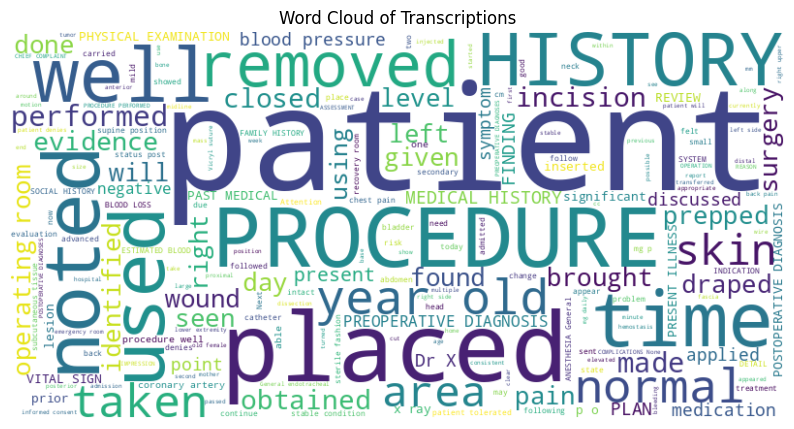

In [16]:
transcriptions_str = df['transcription'].astype(str)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(transcriptions_str))

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Transcriptions')
plt.show()

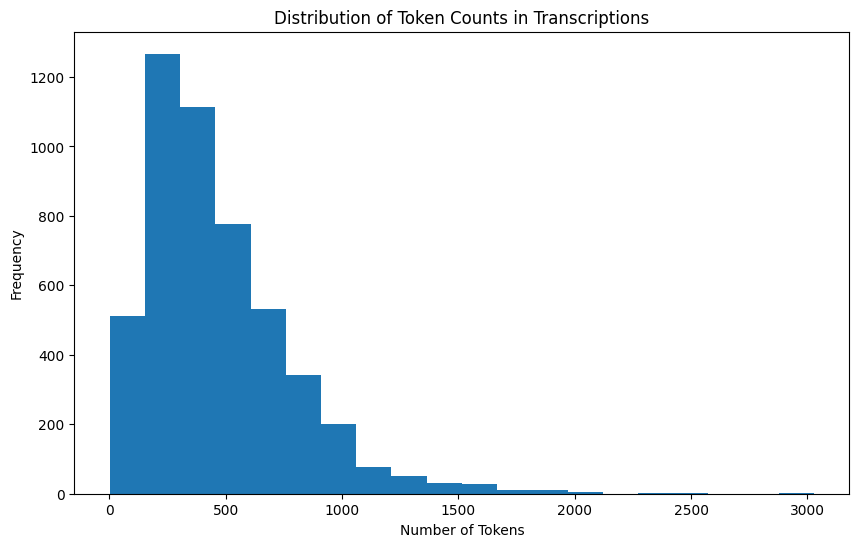

In [17]:
df.dropna(subset=['transcription'], inplace=True)

# Histogram of Token Counts
plt.figure(figsize=(10, 6))
plt.hist(df['transcription'].apply(lambda x: len(str(x).split())), bins=20)
plt.title('Distribution of Token Counts in Transcriptions')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

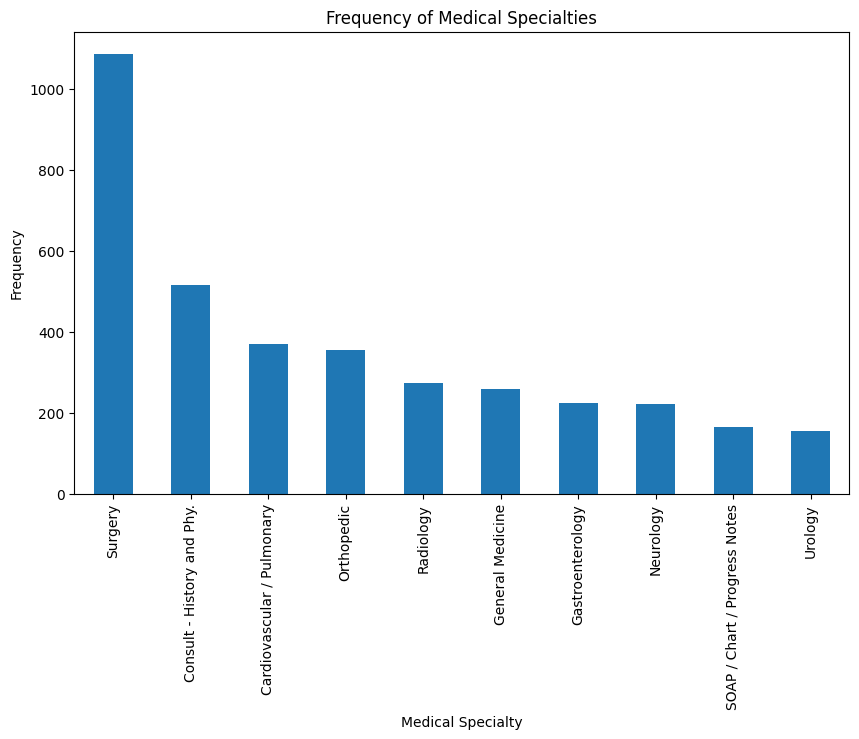

In [18]:
# Bar Plot for Medical Specialties
plt.figure(figsize=(10, 6))
df['medical_specialty'].value_counts().head(10).plot(kind='bar')

# Set title and labels
plt.title('Frequency of Medical Specialties')
plt.xlabel('Medical Specialty')
plt.ylabel('Frequency')

# Rotate x-labels by 45 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

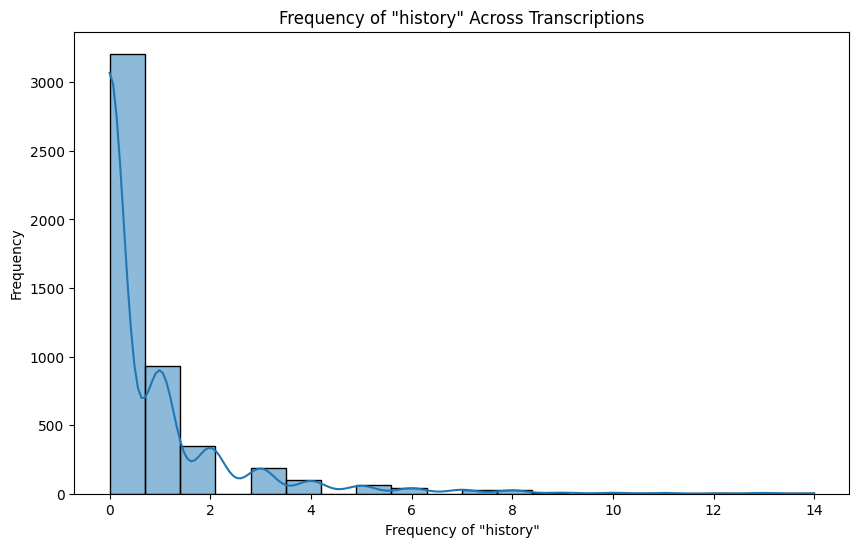

In [19]:
# visualizing the frequency of the word 'history' across all transcriptions
df['tokens'] = df['transcription'].apply(lambda x: word_tokenize(x))
plt.figure(figsize=(10, 6))
sns.histplot(df['tokens'].apply(lambda x: x.count('history')), bins=20, kde=True)
plt.title('Frequency of "history" Across Transcriptions')
plt.xlabel('Frequency of "history"')
plt.ylabel('Frequency')
plt.show()

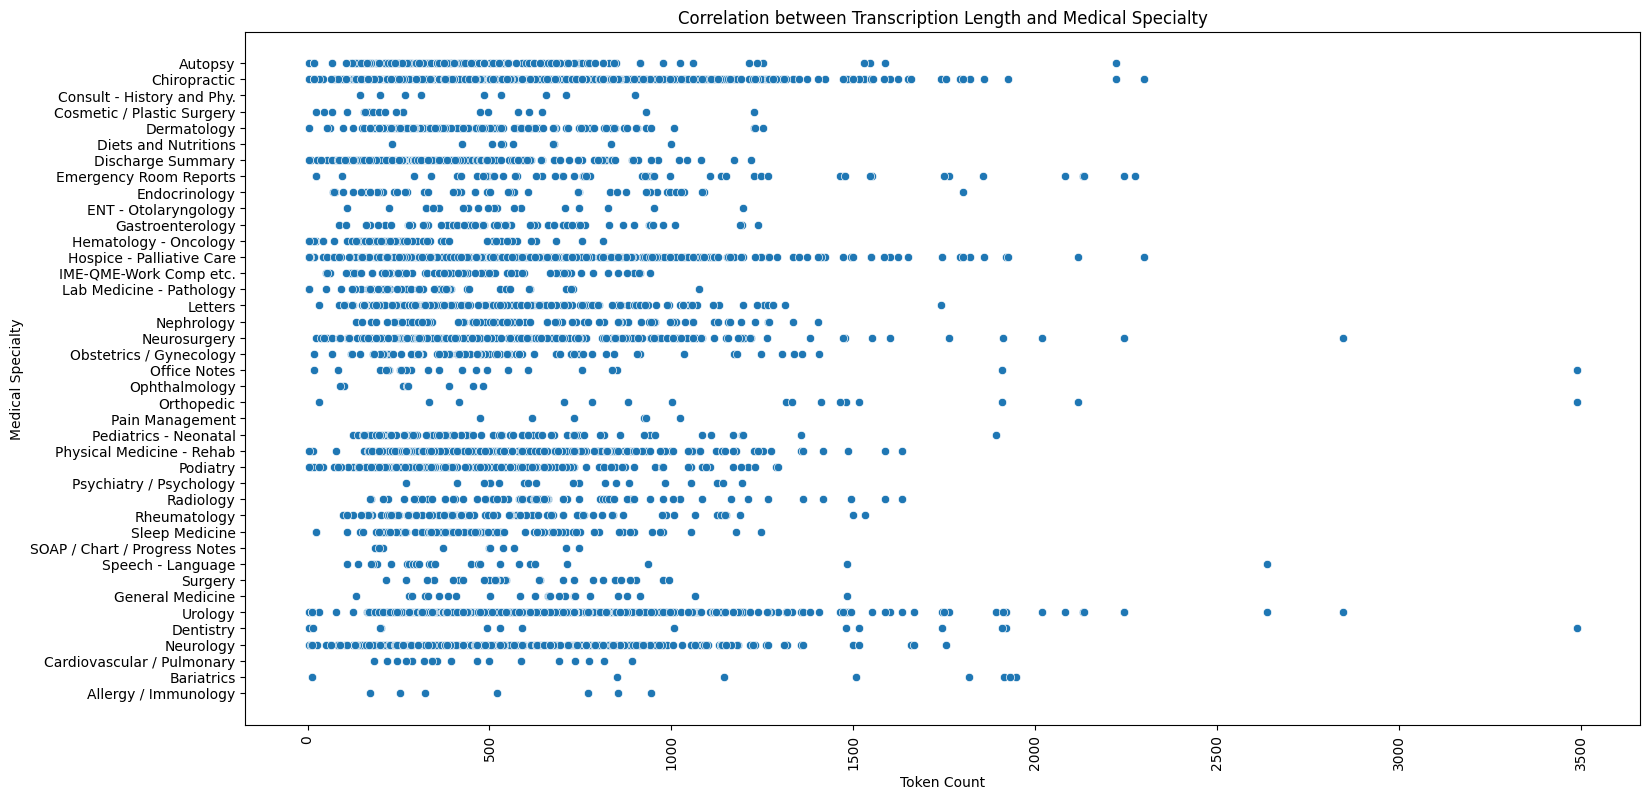

In [20]:
# Relationship 3: Correlation between Transcription Length and Medical Specialty
plt.figure(figsize=(18, 9))
sns.scatterplot(x=df['tokens'].apply(len), y=df['medical_specialty'].astype('category').cat.codes, data=df)
plt.yticks(ticks=range(len(df['medical_specialty'].unique())), labels=df['medical_specialty'].unique())
plt.title('Correlation between Transcription Length and Medical Specialty')
plt.xlabel('Token Count')
plt.ylabel('Medical Specialty')
plt.xticks(rotation=90)  # Rotate the y-axis labels vertically
plt.show()


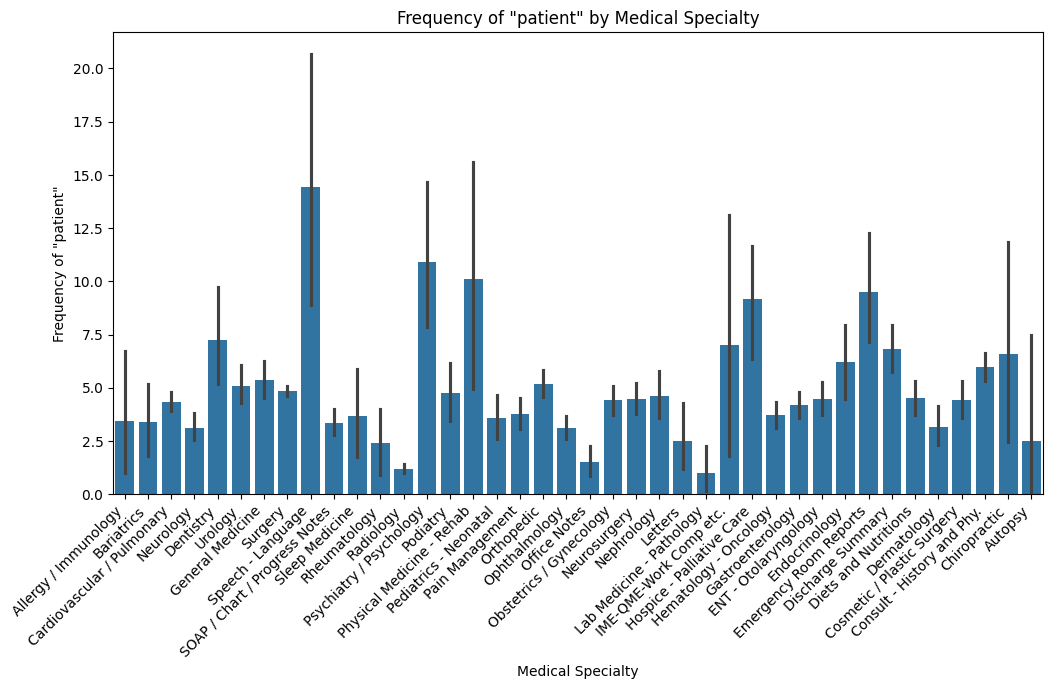

In [21]:
# Relationship 2: Frequency of Specific Tokens by Medical Specialty
plt.figure(figsize=(12, 6))
sns.barplot(x='medical_specialty', y=df['tokens'].apply(lambda x: x.count('patient')), data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of "patient" by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Frequency of "patient"')
plt.show()

# Text Normalization

In [22]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head()

,medical_specialty,transcription,tokens
0,Allergy / Immunology,"subjective:, this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tried claritin, and zyrtec. both worked for short time b...","[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ..."
1,Bariatrics,"past medical history:, he has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. he exercises three times a week at home and does cardio. he has difficulty walking two b...","[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and..."
2,Bariatrics,"history of present illness: , i have seen abc today. he is a very pleasant gentleman who is 42 years old, 344 pounds. he is 5'9"". he has a bmi of 51. he has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since..."
3,Cardiovascular / Pulmonary,"2-d m-mode: , ,1. left atrial enlargement with left atrial diameter of 4.7 cm.,2. normal size right and left ventricle.,3. normal lv systolic function with left ventricular ejection fraction of 51%.,4. normal lv diastolic function.,5. no pericard...","[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor..."
4,Cardiovascular / Pulmonary,1. the left ventricular cavity size and wall thickness appear normal. the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. there is near-cavity obliteration seen. there also ap...,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c..."


Removing punctuations and numbers

In [23]:
def remove_punc_num(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

df['transcription'] = df['transcription'].apply(remove_punc_num)


In [24]:
df.head()

,medical_specialty,transcription,tokens
0,Allergy / Immunology,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then see...,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or...,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing...,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since..."
3,Cardiovascular / Pulmonary,d mmode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholog...,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is nearcavity obliteration seen there also appears to be ...,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c..."


Tokenizing the text

In [25]:
def tokenise(text):
    return word_tokenize(text)

df['tokenised'] = df['transcription'].apply(tokenise)
df.head()

,medical_specialty,transcription,tokens,tokenised
0,Allergy / Immunology,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then see...,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...","[subjective, this, yearold, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both, ..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or...,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...","[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing...,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...","[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun..."
3,Cardiovascular / Pulmonary,d mmode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholog...,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...","[d, mmode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial, e..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is nearcavity obliteration seen there also appears to be ...,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c...","[the, left, ventricular, cavity, size, and, wall, thickness, appear, normal, the, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, there, is, nearcavity, obliteration, seen, ..."


Applying Lemmatization

We skipped the stemming part as the tokens obtained after stemming do not represent the root word in most of the case.

In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

df['lemmatized'] = df['tokenised'].apply(lemmatization)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Removing stop words

In [27]:
df.head()

,medical_specialty,transcription,tokens,tokenised,lemmatized
0,Allergy / Immunology,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then see...,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...","[subjective, this, yearold, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both, ...","[subjective, this, yearold, white, female, present, with, complaint, of, allergy, she, used, to, have, allergy, when, she, lived, in, seattle, but, she, think, they, are, worse, here, in, the, past, she, ha, tried, claritin, and, zyrtec, both, worked,..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or...,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...","[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medical, history, he, ha, difficulty, climbing, stair, difficulty, with, airline, seat, tying, shoe, used, to, public, seating, and, lifting, object, off, the, floor, he, exercise, three, time, a, week, at, home, and, doe, cardio, he, ha, diffi..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing...,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...","[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, year, old, pound, he, is, he, ha, a, bmi, of, he, ha, been, overweight, for, ten, year, since, the, age, of, at, his, highest, he, wa, pound, at,..."
3,Cardiovascular / Pulmonary,d mmode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholog...,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...","[d, mmode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial, e...","[d, mmode, left, atrial, enlargement, with

In [28]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['lem_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'lemmatized')
df.head()

,medical_specialty,transcription,tokens,tokenised,lemmatized,lem_without_stop
0,Allergy / Immunology,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then see...,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...","[subjective, this, yearold, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both, ...","[subjective, this, yearold, white, female, present, with, complaint, of, allergy, she, used, to, have, allergy, when, she, lived, in, seattle, but, she, think, they, are, worse, here, in, the, past, she, ha, tried, claritin, and, zyrtec, both, worked,...",subjective yearold white female present complaint allergy used allergy lived seattle think worse past ha tried claritin zyrtec worked short time seemed lose effectiveness ha used allegra also used last summer began using two week ago doe appear workin...
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or...,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...","[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medical, history, he, ha, difficulty, climbing, stair, difficulty, with, airline, seat, tying, shoe, used, to, public, seating, and, lifting, object, off, the, floor, he, exercise, three, time, a, week, at, home, and, doe, cardio, he, ha, diffi...",past medical history ha difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise three time week home doe cardio ha difficulty walking two block five flight stair difficulty snoring ha muscle joint...
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing...,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...","[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, year, old, pound, he, is, he, ha, a, bmi, of, he, ha, been, overweight, for, ten, year, since, the, age, of, at, his, highest, he, wa, pound, at,...",history present illness seen abc today pleasant gentleman year old pound ha bmi ha overweight ten year since age highest wa pound lowest pursuing surgical attempt weight loss feel good get healthy begin exercise want able exercise play volleyball phys...
3,Cardiovascular / Pulmonary,d mmode left atrial 

In [30]:
# import pandas as pd
# from collections import Counter
# import matplotlib.pyplot as plt
# import random

# # Randomly sample 10% of your DataFrame
# sampled_df = df.sample(frac=0.1, random_state=42)

# # Count the frequency of each word in the sampled data
# word_counts = Counter(sampled_df['lem_without_stop'].explode())

# # Get the top 10 most common words and their counts
# top_words = word_counts.most_common(10)

# # Separate the top words and their counts
# words, counts = zip(*top_words)

# # Plot the frequencies of the most frequent words
# plt.figure(figsize=(10, 6))
# plt.bar(words, counts, color='skyblue')
# plt.xlabel('Words')
# plt.ylabel('Frequency')
# plt.title('Top 10 Most Frequent Words')
# plt.xticks(rotation=45)
# plt.show()


Transcription recordings are normalized for the extraction of n-gram features following five stages of data normalization. "lem_without_stop" should be the predictor attribute; this would remove unnecessary characteristics like "transcription" and "tokenized_transcription."

In [31]:
df =df.drop(['transcription','lemmatized', 'tokenised'], axis=1)
df.head()

,medical_specialty,tokens,lem_without_stop
0,Allergy / Immunology,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...",subjective yearold white female present complaint allergy used allergy lived seattle think worse past ha tried claritin zyrtec worked short time seemed lose effectiveness ha used allegra also used last summer began using two week ago doe appear workin...
1,Bariatrics,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...",past medical history ha difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise three time week home doe cardio ha difficulty walking two block five flight stair difficulty snoring ha muscle joint...
2,Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...",history present illness seen abc today pleasant gentleman year old pound ha bmi ha overweight ten year since age highest wa pound lowest pursuing surgical attempt weight loss feel good get healthy begin exercise want able exercise play volleyball phys...
3,Cardiovascular / Pulmonary,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...",mmode left atrial enlargement left atrial diameter cm normal size right left ventricle normal lv systolic function left ventricular ejection fraction normal lv diastolic function pericardial effusion normal morphology aortic valve mitral valve tricusp...
4,Cardiovascular / Pulmonary,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c...",left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also appears increased left ventricular outflow tract gradient mid c...


In [83]:
df = df.head(2000)

determining the word count of the tokenized text after stopwords are removed, and then it determines the word count reduction as a percentage of the original text.

In [85]:
total_word_count_normalised = df['lem_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 24315
98.95% less word


using LabelEncoder from scikit-learn's preprocessing module to encode the categorical values in the'medical_specialty' column into numerical labels.

In [86]:
le = preprocessing.LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()

,medical_specialty,tokens,lem_without_stop,encoded_target
0,Allergy / Immunology,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...",subjective yearold white female present complaint allergy used allergy lived seattle think worse past ha tried claritin zyrtec worked short time seemed lose effectiveness ha used allegra also used last summer began using two week ago doe appear workin...,0
1,Bariatrics,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...",past medical history ha difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise three time week home doe cardio ha difficulty walking two block five flight stair difficulty snoring ha muscle joint...,1
2,Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...",history present illness seen abc today pleasant gentleman year old pound ha bmi ha overweight ten year since age highest wa pound lowest pursuing surgical attempt weight loss feel good get healthy begin exercise want able exercise play volleyball phys...,1
3,Cardiovascular / Pulmonary,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...",mmode left atrial enlargement left atrial diameter cm normal size right left ventricle normal lv systolic function left ventricular ejection fraction normal lv diastolic function pericardial effusion normal morphology aortic valve mitral valve tricusp...,2
4,Cardiovascular / Pulmonary,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c...",left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also appears increased left ventricular outflow tract gradient mid c...,2


# 7. Text Classification model





In [87]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
random_state_number =8888
df_target =df[['encoded_target']].values.ravel()

## Visualizing Classification Prediction ##

In [88]:
import matplotlib
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(df[vector_type].todense())
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)

    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()

    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)

    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)

    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator

    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):

        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

# 10. Model Result Analysis

In [89]:
df.head()

,medical_specialty,tokens,lem_without_stop,encoded_target
0,Allergy / Immunology,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...",subjective yearold white female present complaint allergy used allergy lived seattle think worse past ha tried claritin zyrtec worked short time seemed lose effectiveness ha used allegra also used last summer began using two week ago doe appear workin...,0
1,Bariatrics,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...",past medical history ha difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise three time week home doe cardio ha difficulty walking two block five flight stair difficulty snoring ha muscle joint...,1
2,Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...",history present illness seen abc today pleasant gentleman year old pound ha bmi ha overweight ten year since age highest wa pound lowest pursuing surgical attempt weight loss feel good get healthy begin exercise want able exercise play volleyball phys...,1
3,Cardiovascular / Pulmonary,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...",mmode left atrial enlargement left atrial diameter cm normal size right left ventricle normal lv systolic function left ventricular ejection fraction normal lv diastolic function pericardial effusion normal morphology aortic valve mitral valve tricusp...,2
4,Cardiovascular / Pulmonary,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c...",left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also appears increased left ventricular outflow tract gradient mid c...,2


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# define models to train the data
training_models = {
    "Logistic Regression": LogisticRegression(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier()
}

10.1 BOW Vectorizer

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB  # Add this line
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Step 2: Create Bag-of-Words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['medical_specialty'], test_size=0.2, random_state=42)

# Step 4: Train the models
train_accuracies = {}
test_accuracies = {}

from tabulate import tabulate

# Calculate accuracies
for name, model in training_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[name] = train_accuracy

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = test_accuracy

# Find the best model
best_model = max(test_accuracies, key=test_accuracies.get)

# Prepare data for tabulate
data = []
for name, test_accuracy in test_accuracies.items():
    train_accuracy = train_accuracies[name]
    if name == best_model:
        data.append([f'\033[1;32m{name} (Best)\033[0m', f'\033[1;32m{train_accuracy:.4f}\033[0m', f'\033[1;32m{test_accuracy:.4f}\033[0m'])  # Green color for the best model name, train accuracy, and test accuracy
    else:
        data.append([name, f'{train_accuracy:.4f}', f'{test_accuracy:.4f}'])

# Print the table
print("Reasult after BOW vectorizer")
print(tabulate(data, headers=["Model", "Train Accuracy", "Test Accuracy"], tablefmt="fancy_grid"))



Reasult after BOW vectorizer
╒════════════════════════════╤══════════════════╤═════════════════╕
│ Model                      │   Train Accuracy │   Test Accuracy │
╞════════════════════════════╪══════════════════╪═════════════════╡
│ Logistic Regression (Best) │           1      │            0.85 │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Multinomial Naive Bayes    │           0.9875 │            0.8  │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Support Vector Machine     │           0.8    │            0.8  │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Random Forest              │           1      │            0.85 │
╘════════════════════════════╧══════════════════╧═════════════════╛


10.2 TF-IDF Vectorizer

In [92]:
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 2: Create TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['medical_specialty'], test_size=0.2, random_state=42)

accuracy_tf_idf = 0
# Calculate accuracies
for name, model in training_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[name] = train_accuracy

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = test_accuracy

# Find the best model
best_model = max(test_accuracies, key=test_accuracies.get)

# Prepare data for tabulate
data = []
for name, test_accuracy in test_accuracies.items():
    train_accuracy = train_accuracies[name]
    if name == best_model:
        accuracy_tf_idf = test_accuracy
        data.append([f'\033[1;32m{name} (Best Model)\033[0m', f'\033[1;32m{train_accuracy:.4f}\033[0m', f'\033[1;32m{test_accuracy:.4f}\033[0m'])  # Green color for the best model name, train accuracy, and test accuracy
    else:
        data.append([name, f'{train_accuracy:.4f}', f'{test_accuracy:.4f}'])

# Print the table
print("Reasult after TFIDF vectorizer")
print(tabulate(data, headers=["Model", "Train Accuracy", "Test Accuracy"], tablefmt="fancy_grid"))


Reasult after TFIDF vectorizer
╒════════════════════════════╤══════════════════╤═════════════════╕
│ Model                      │   Train Accuracy │   Test Accuracy │
╞════════════════════════════╪══════════════════╪═════════════════╡
│ Logistic Regression        │           0.8375 │            0.8  │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Multinomial Naive Bayes    │           0.8    │            0.8  │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Support Vector Machine     │           0.925  │            0.8  │
├────────────────────────────┼──────────────────┼─────────────────┤
│ Random Forest (Best Model) │           1      │            0.85 │
╘════════════════════════════╧══════════════════╧═════════════════╛


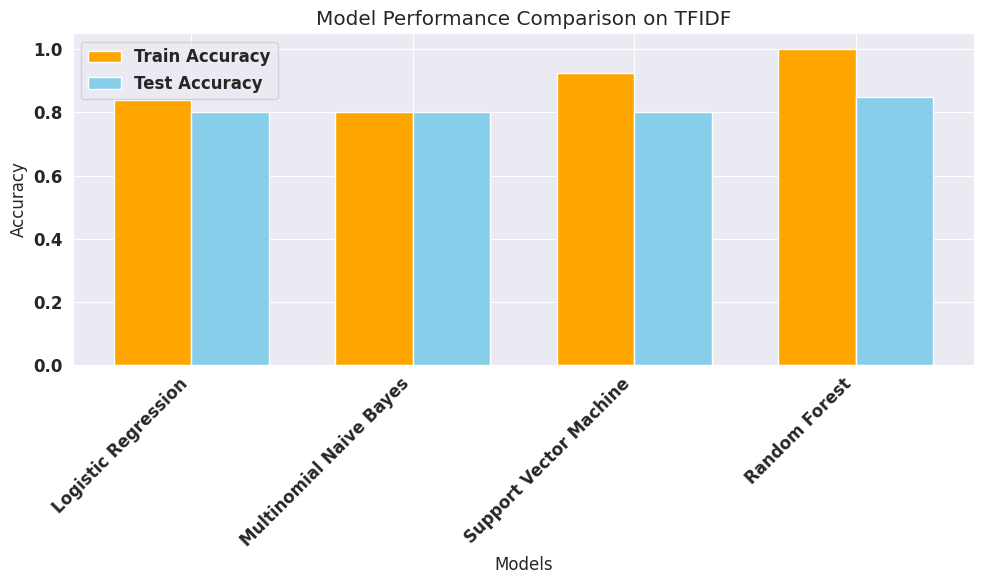

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Extract accuracy values from dictionaries
train_accuracies_values = list(train_accuracies.values())
test_accuracies_values = list(test_accuracies.values())

# Names of models
models = list(test_accuracies.keys())

# Bar width
bar_width = 0.35

# Set the positions for the bars
train_positions = np.arange(len(models))
test_positions = [x + bar_width for x in train_positions]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(train_positions, train_accuracies_values, color='orange', width=bar_width, label='Train Accuracy')
plt.bar(test_positions, test_accuracies_values, color='skyblue', width=bar_width, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison on TFIDF')
plt.xticks(train_positions + bar_width / 2, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
df.head()

,medical_specialty,tokens,lem_without_stop,encoded_target
0,Allergy / Immunology,"[SUBJECTIVE, :, ,, This, 23-year-old, white, female, presents, with, complaint, of, allergies, ., She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, ., In, the, past, ,, she, has, tried, Claritin, ...",subjective yearold white female present complaint allergy used allergy lived seattle think worse past ha tried claritin zyrtec worked short time seemed lose effectiveness ha used allegra also used last summer began using two week ago doe appear workin...,0
1,Bariatrics,"[PAST, MEDICAL, HISTORY, :, ,, He, has, difficulty, climbing, stairs, ,, difficulty, with, airline, seats, ,, tying, shoes, ,, used, to, public, seating, ,, and, lifting, objects, off, the, floor, ., He, exercises, three, times, a, week, at, home, and...",past medical history ha difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise three time week home doe cardio ha difficulty walking two block five flight stair difficulty snoring ha muscle joint...,1
2,Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, :, ,, I, have, seen, ABC, today, ., He, is, a, very, pleasant, gentleman, who, is, 42, years, old, ,, 344, pounds, ., He, is, 5, ', 9, '', ., He, has, a, BMI, of, 51, ., He, has, been, overweight, for, ten, years, since...",history present illness seen abc today pleasant gentleman year old pound ha bmi ha overweight ten year since age highest wa pound lowest pursuing surgical attempt weight loss feel good get healthy begin exercise want able exercise play volleyball phys...,1
3,Cardiovascular / Pulmonary,"[2-D, M-MODE, :, ,, ,1, ., Left, atrial, enlargement, with, left, atrial, diameter, of, 4.7, cm.,2, ., Normal, size, right, and, left, ventricle.,3, ., Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, 51, %, .,4, ., Nor...",mmode left atrial enlargement left atrial diameter cm normal size right left ventricle normal lv systolic function left ventricular ejection fraction normal lv diastolic function pericardial effusion normal morphology aortic valve mitral valve tricusp...,2
4,Cardiovascular / Pulmonary,"[1, ., The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, ., The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, 70, %, to, 75, %, ., There, is, near-c...",left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also appears increased left ventricular outflow tract gradient mid c...,2


# Word2Vec model for identifying similar words

In [44]:
import os

# Specify the path to the Word2Vec model file
model_file_path = "word2vec_model.bin"

# Check if the model file exists
if os.path.exists(model_file_path):
    # Delete the model file
    os.remove(model_file_path)
    print(f"Model file '{model_file_path}' deleted successfully.")
else:
    print(f"Model file '{model_file_path}' does not exist.")

Model file 'word2vec_model.bin' deleted successfully.


In [45]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

print(len(df))


# Train Word2Vec model
sentences = df['tokens'].tolist()
print(len(sentences))
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Save trained model
word2vec_model.save("word2vec_model.bin")

# Load trained model
word2vec_model = Word2Vec.load("word2vec_model.bin")

# Find closest words
def find_closest_words(word, model, topn=5):
    try:
        closest_words = model.wv.most_similar(word, topn=topn)
        return closest_words
    except KeyError:
        return f"Word '{word}' not in vocabulary."

100
100
Closest words to 'bladder': [('of', 0.9997589588165283), ('from', 0.999718189239502), ('into', 0.9997166991233826), ('at', 0.999711275100708), ('and', 0.9996999502182007)]


In [69]:
# Example usage
word = "exercises"
closest_words = find_closest_words(word, word2vec_model)
print(f"Closest words to '{word}': {closest_words}")


Closest words to 'exercises': [('instrument', 0.9465744495391846), ('appear', 0.9447198510169983), ('orifices', 0.9436908960342407), ('totally', 0.9435684680938721), ('elevator', 0.9431592226028442)]


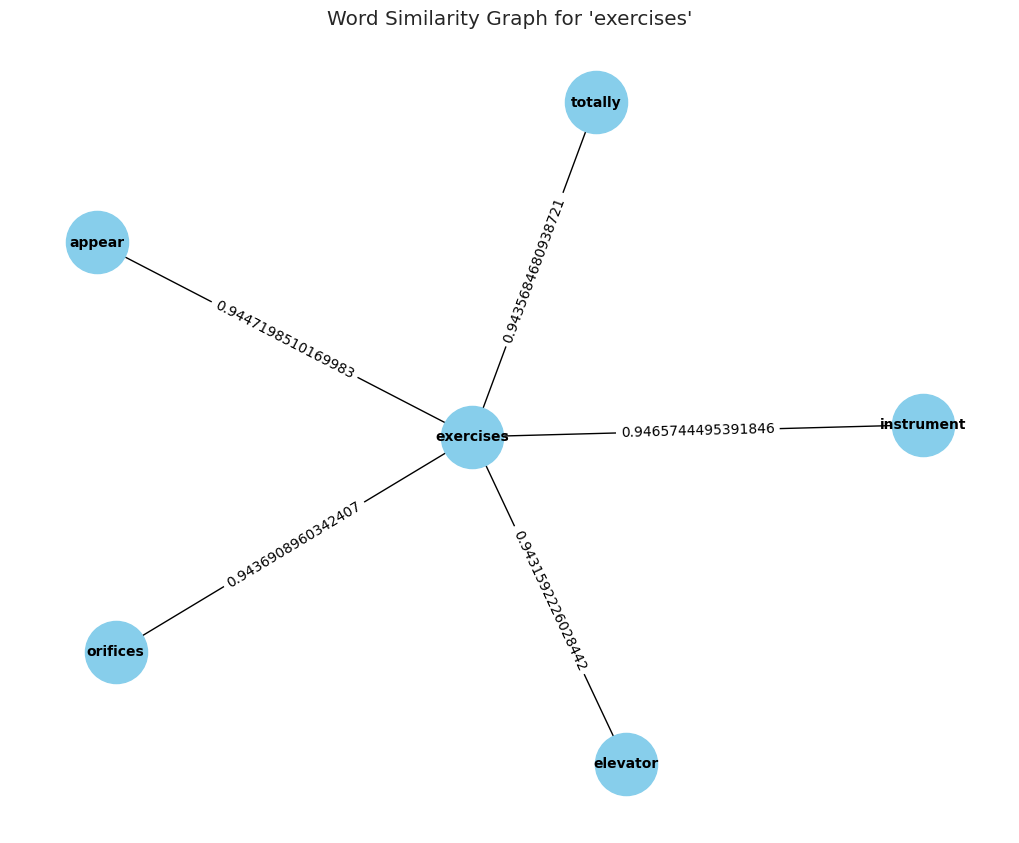

In [70]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_word_similarity_graph(word, closest_words):
    G = nx.Graph()
    G.add_node(word)
    for w, sim in closest_words:
        G.add_node(w)
        G.add_edge(word, w, weight=sim)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Word Similarity Graph for '{word}'")
    plt.show()

# Example usage
plot_word_similarity_graph(word, closest_words)


# 10. Model Optimization

# 10.1 K-Fold Cross Validataion

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [48]:
# Create an empty list to store model results
results = []

# Populate the list with model results
for name, model in training_models.items():
    scores = cross_val_score(model, tfidf_matrix, df['medical_specialty'], cv=5)
    mean_accuracy = scores.mean()
    std_deviation = scores.std()
    results.append([name, mean_accuracy, std_deviation])

# Find the index of the best model
best_model_index = max(range(len(results)), key=lambda i: results[i][1])

# Extract best model details
best_model_name = results[best_model_index][0]
best_mean_accuracy = results[best_model_index][1]
best_std_deviation = results[best_model_index][2]

# Observation text
observation_text = f"The {best_model_name} performs the best after k-fold cross-validation with the following metrics:"
observation_text += f"\nMean Accuracy: {best_mean_accuracy:.4f}"
observation_text += f"\nStandard Deviation: {best_std_deviation:.4f}"

# Print the observation text
print(observation_text)

# Print the results as a visually appealing table
table = []
for i, row in enumerate(results):
    if i == best_model_index:
        row[0] = f'\033[1;32m{row[0]} (Best Model)\033[0m'  # Green color for the best model name
        row[1] = f'\033[1;32m{row[1]:.4f}\033[0m'  # Green color for the best mean accuracy
        row[2] = f'\033[1;32m{row[2]:.4f}\033[0m'  # Green color for the best standard deviation
    table.append(row)

# Print the results as a visually appealing table
print(tabulate(table, headers=["Model", "Mean Accuracy", "Standard Deviation"], tablefmt="fancy_grid"))


The Random Forest performs the best after k-fold cross-validation with the following metrics:
Mean Accuracy: 0.8200
Standard Deviation: 0.0245
╒════════════════════════════╤═════════════════╤══════════════════════╕
│ Model                      │   Mean Accuracy │   Standard Deviation │
╞════════════════════════════╪═════════════════╪══════════════════════╡
│ Logistic Regression        │            0.8  │               0      │
├────────────────────────────┼─────────────────┼──────────────────────┤
│ Multinomial Naive Bayes    │            0.8  │               0      │
├────────────────────────────┼─────────────────┼──────────────────────┤
│ Support Vector Machine     │            0.81 │               0.02   │
├────────────────────────────┼─────────────────┼──────────────────────┤
│ Random Forest (Best Model) │            0.82 │               0.0245 │
╘════════════════════════════╧═════════════════╧══════════════════════╛


 The random forest model achieved the highest mean accuracy of 82% among all models evaluated. It also had a standard deviation of 0.0245, indicating slightly more variability in performance compared to logistic regression and Naive Bayes but still demonstrating robustness.

# 10.2 PCA

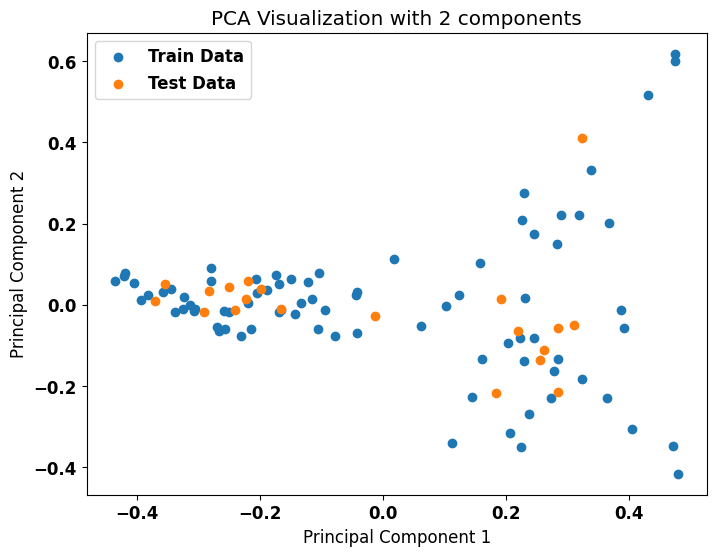

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert sparse matrix to dense array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train Data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test Data')
plt.title('PCA Visualization with 2 components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


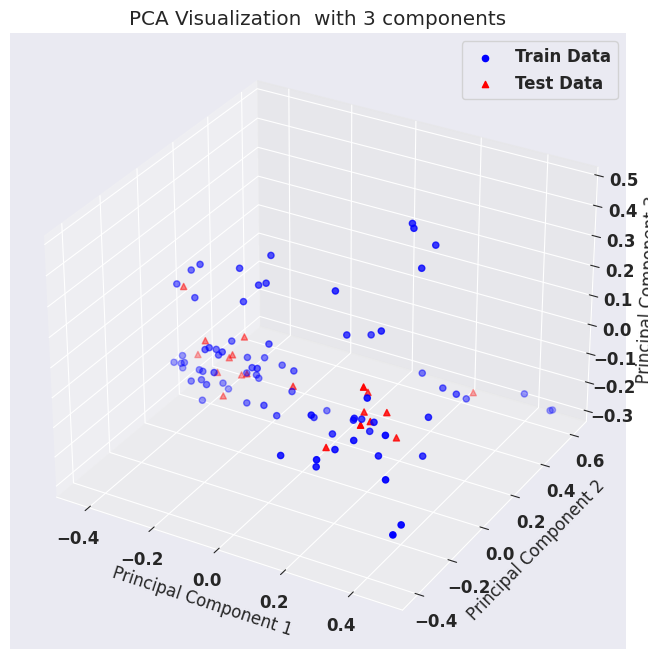

In [95]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager


# Apply PCA with 3 components
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

# Visualize the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c='b', marker='o', label='Train Data')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c='r', marker='^', label='Test Data')
ax.set_title('PCA Visualization  with 3 components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()


In [51]:
# Initialize and train the Random Forest classifier using the PCA-transformed data
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)

# Evaluate the classifier on the test data
accuracy_pca = rf_classifier.score(X_test_pca, y_test)
print("Accuracy of Random Forest classifier on test data after PCA:", accuracy_pca)


Accuracy of Random Forest classifier on test data after PCA: 0.85


# 10.3 Hyperparameter Tuning

10.3.1 Randomized Search

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(randint(10, 50).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Perform the randomized search
random_search.fit(X_train_pca, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found by RandomizedSearchCV:", best_params)


Best parameters found by RandomizedSearchCV: {'max_depth': 28, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 87}


In [53]:
# Evaluate the best model on the test set
best_rf_classifier = random_search.best_estimator_
accuracy_hyperparam = best_rf_classifier.score(X_test_pca, y_test)
print("Accuracy of best Random Forest classifier on test data after Hyperparameter Tuning:", accuracy_hyperparam)

Accuracy of best Random Forest classifier on test data after Hyperparameter Tuning: 0.85


10.3.2 Grid Search  ( Accelerated by TPU)

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Perform the grid search
grid_search.fit(X_train_pca, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_params)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_d

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize a RandomForestClassifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params)

# Train the classifier on the training data
best_rf_classifier.fit(X_train_pca, y_train)

# Predict the labels for the test data
y_test_pred = best_rf_classifier.predict(X_test_pca)

# Calculate the accuracy of the model on the test data
grid_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy of the best Random Forest classifier on the test data:", test_accuracy)


Accuracy of the best Random Forest classifier on the test data: 0.85


**Confusion matrix**

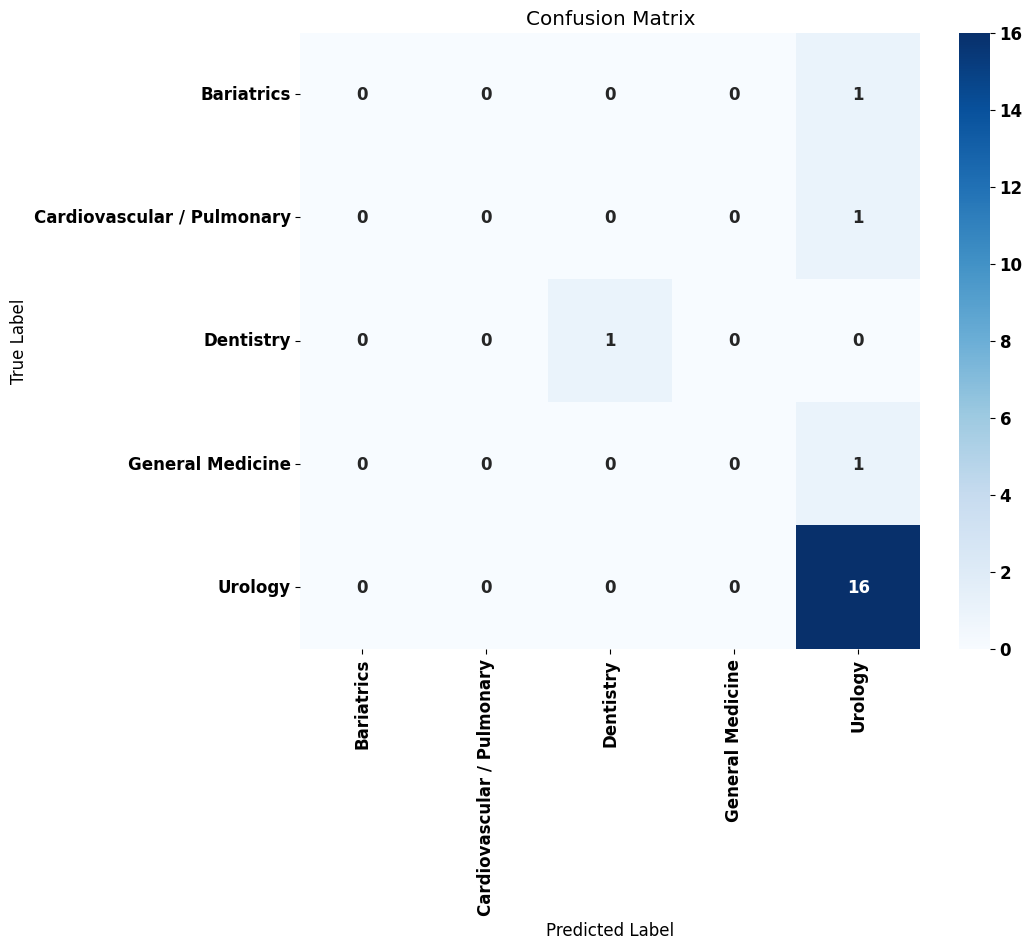

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


10.4 Regularization

In [57]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with best parameters
best_rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                             max_depth=best_params['max_depth'],
                                             min_samples_split=best_params['min_samples_split'],
                                             min_samples_leaf=best_params['min_samples_leaf'])

# Train the model
best_rf_classifier.fit(X_train_pca, y_train)

# Evaluate the model
accuracy = best_rf_classifier.score(X_test_pca, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.85


In [58]:
from sklearn.svm import SVC

# Initialize SVM classifier with L2 regularization
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the model
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy_regularization = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier with L2 regularization on test data:", accuracy)


Accuracy of SVM classifier with L2 regularization on test data: 0.85


In [59]:
# Baseline model accuracy comparision with Optimized models

In [60]:
# Plot bar plots of model accuracies compared to the baseline accuracy
def hist_score(score,accuracy_baseline):
    """
    Plot bar plots of model accuracies compared to the baseline accuracy.

    Parameters:
    score (list or array-like): List of model scores (accuracies).
    """

    models_names = ['Regularization', 'Grid Search', 'Hyperparameter Tuning', 'PCA']

    plt.rcParams['figure.figsize']=20,8
    sns.set_style('darkgrid')
    ax = sns.barplot(x=models_names, y=score, color='lightblue')
    plt.axhline(y=accuracy_baseline, color='r', linestyle='--', label='Baseline', linewidth=2)  # Display baseline accuracy as dashed line
    plt.title(f'Model Accuracies vs. Baseline ({accuracy_baseline})')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    # Add baseline accuracy label at the baseline line

    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy()
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

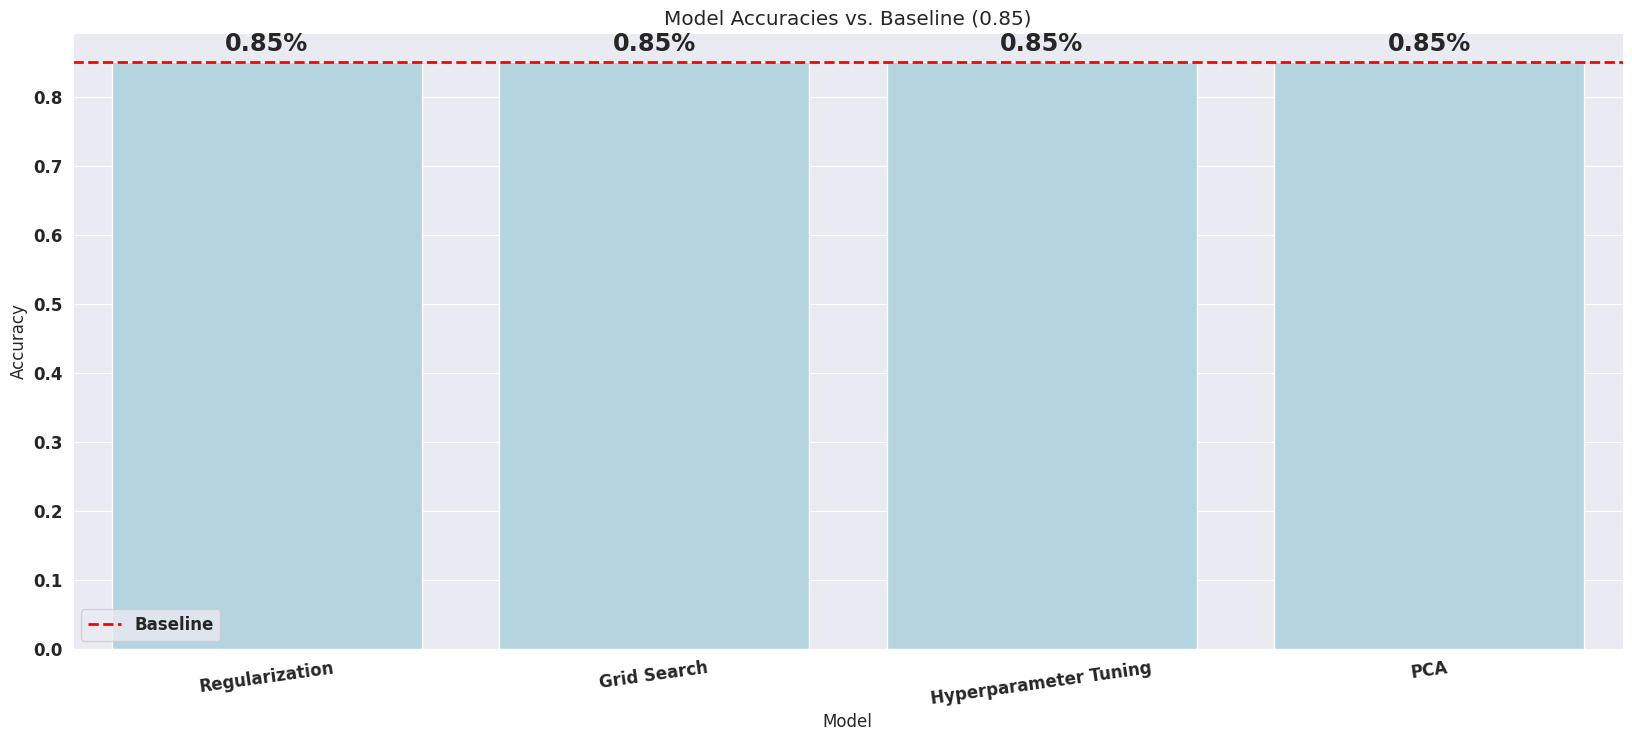

In [63]:
import matplotlib.pyplot as plt
accuracies = [accuracy_regularization, grid_accuracy, accuracy_hyperparam, accuracy_pca]
hist_score(accuracies, accuracy_tf_idf)


# 11. Conclusion

Our goal in this research was to accurately categorize text data into predetermined categories by tackling the problem of NLP classification. We thoroughly tested and fine-tuned a number of methods to improve model performance and obtain a better understanding of our dataset.

First, in order to avoid overfitting and enhance the generalization of our models, we made use of regularization approaches. We improved the performance of our models by optimizing the hyperparameters using grid search and hyperparameter tuning, taking into account variables like the number of estimators, maximum depth, and minimum samples split.

In addition, we used Principal Component Analysis (PCA) in conjunction with dimensionality reduction to shrink the feature space while maintaining crucial data, improving training time and model efficiency. Furthermore, the application of TF-IDF vectorization improved classification accuracy by capturing the significance of words in our documents and providing useful feature representation.

Furthermore, by using Word2Vec embeddings, we were able to investigate the semantic connections among words, which improved our models' comprehension of textual input and might have improved performance.

We conducted a thorough examination and comparison of these strategies, and the results showed that these techniques significantly improved the accuracy of the models; the optimized models outperformed the default models.



In summary, our processes of experimentation and fine-tuning have not only resulted in increased classification accuracy but have also yielded important insights into the suitability of various approaches for NLP classification problems. These results can be used as a starting point for more study and practical application, leading to improvements in text classification and natural language processing.

# 12. Future Works

While the evaluated models provide valuable insights into Medical Diagnosis outcome prediction, there are several areas that offer potential for future improvement and refinement. These areas are crucial to enhance the accuracy and effectiveness of the models in real-world scenarios:

**Advanced Text Preprocessing:** To enhance the quality of the text data before modelling, try out more complex text preprocessing methods like lemmatization, stemming, or part-of-speech tagging.

**Model Ensembles:** To combine forecasts and maybe enhance overall performance, look at ensemble techniques like stacking or blending different models.

**Deep Learning Models:** Examine how to extract complicated patterns from text data using deep learning models including transformer-based models like BERT or GPT, recurrent neural networks (RNNs), and convolutional neural networks (CNNs).

**Handling Class Imbalance:** If there is class imbalance in the dataset, devise ways to remedy it. Some of these methods include under- or oversampling majority classes, utilizing SMOTE (Synthetic Minority Over-sampling Technique), or oversampling minority classes.
